# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import numba 
from matplotlib import rc
import tissue_enrichment_analysis as ea

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
strains =['ps4187', 'ps4087', 'ps4176']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [3]:
q = 0.1

In [4]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../input/quantifications.csv')

tidy = tidy[tidy.strain.isin(strains)]

In [5]:
overlap_sy622_het = epi.find_overlap(['ps4087', 'ps4176'], tidy, q=q)
overlap_bx93_het = epi.find_overlap(['ps4187', 'ps4176'], tidy, q=q)
overlap_sy622_bx93 = epi.find_overlap(['ps4187', 'ps4087'], tidy, q=q)

In [6]:
sy622_associated = tidy[tidy.target_id.isin(overlap_sy622_het) & (~tidy.target_id.isin(overlap_sy622_bx93))].target_id.unique()
bx93_associated = tidy[tidy.target_id.isin(overlap_bx93_het) | (tidy.target_id.isin(overlap_sy622_bx93))].target_id.unique()
# bx93_associated = tidy[tidy.target_id.isin(overlap_bx93_het)].target_id.unique()

bx93_specific = tidy[(~tidy.target_id.isin(overlap_sy622_bx93)) & (~tidy.target_id.isin(overlap_bx93_het)) & (tidy.qval < q) &
                     (tidy.strain == 'ps4187')].target_id.unique()

sy622_specific = tidy[(~tidy.target_id.isin(overlap_sy622_bx93)) & (~tidy.target_id.isin(overlap_sy622_het)) & (tidy.qval < q) &
                      (tidy.strain == 'ps4087')].target_id.unique()

transhet_specific = tidy[(~tidy.target_id.isin(overlap_bx93_het)) & (~tidy.target_id.isin(overlap_sy622_het)) & (tidy.qval < q)
                         & (tidy.strain == 'ps4176')].target_id.unique()


classes = {'sy622 associated': sy622_associated,
           'bx93 associated': bx93_associated,
           'sy622 specific': sy622_specific,
           'bx93 specific': bx93_specific,
           'transhet specific': transhet_specific}

In [7]:
inv_classes = {}

for key, value in classes.items():
    n = len(tidy[tidy.target_id.isin(value)].ens_gene.unique())
    print(key, n)
    
    for v in value:
        inv_classes[v] = key

sy622 specific 1477
transhet specific 1536
sy622 associated 825
bx93 specific 43
bx93 associated 296


In [8]:
tidy['phenotypic class'] = tidy.target_id.map(inv_classes)

bx93 associated mean: 1.3, median: 0.96
bx93 associated 95 percentile: 4.1
sy622 associated mean: 1.1, median: 0.63
sy622 associated 95 percentile: 3.6
sy622 specific mean: 0.95, median: 0.61
sy622 specific 95 percentile: 3.1


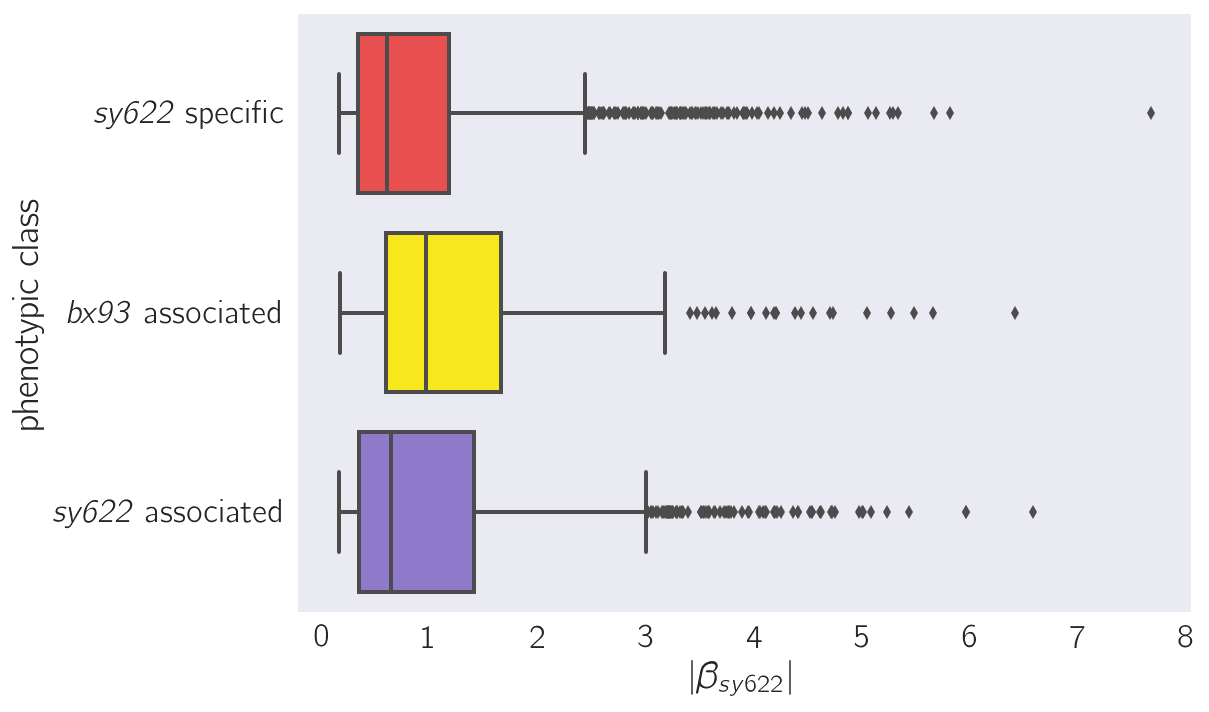

In [9]:
temp = tidy[(tidy.qval < q) & (tidy.strain == 'ps4087')].dropna().copy()
temp.b = temp.b.abs()
sns.boxplot(y='phenotypic class', x='b', data=temp)
plt.xlabel(r'$|\beta_{sy622}|$')
plt.gca().set_yticklabels([r'\emph{sy622} specific', r'\emph{bx93} associated', r'\emph{sy622} associated'])

plt.gca().artists[0].set_facecolor('#E85050')
plt.gca().artists[1].set_facecolor('#F7E71D')
plt.gca().artists[2].set_facecolor('#8F79CA')
plt.savefig('../output/beta_values_phenotypic_classes_sy622.svg', bbox_inches='tight')

grouped = temp.groupby('phenotypic class')
for name, group in grouped:
    print("{0} mean: {1:.2g}, median: {2:.2g}".format(name, group.b.mean(), np.median(group.b)))
    print("{0} 95 percentile: {1:.2g}".format(name, group.b.quantile(.95)))

In [10]:
def bootstrap_difference_of_statistic(x, y, n=10**4, statistic=np.mean):
    """Given two datasets, return a pvalue for null H (means are the same)."""
    nx = len(x)
    ny = len(y)
    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y


    @numba.jit(nopython=True)
    def bootstrap(mixed, nx, ny, n):
        delta = np.zeros(n)
        for i in np.arange(n):
            nullx = np.random.choice(mixed, nx, replace=True)
            nully = np.random.choice(mixed, ny, replace=True)
            diff = statistic(nully) - statistic(nullx)
            delta[i] = diff
        return delta

    delta = bootstrap(mixed, nx, ny, n)
    return delta

def significance(pval, alpha, x, y):
    if pval < alpha:
        print('The medians between {0} and {1} are statistically significantly different.'.format(x, y))
    else:
        print('The medians between {0} and {1} are NOT statistically significantly different.'.format(x, y))
    print('pvalue is {0:.2g}'.format(pval))

The medians between bx93 associated and sy622 associated are statistically significantly different.
pvalue is 1.7e-05


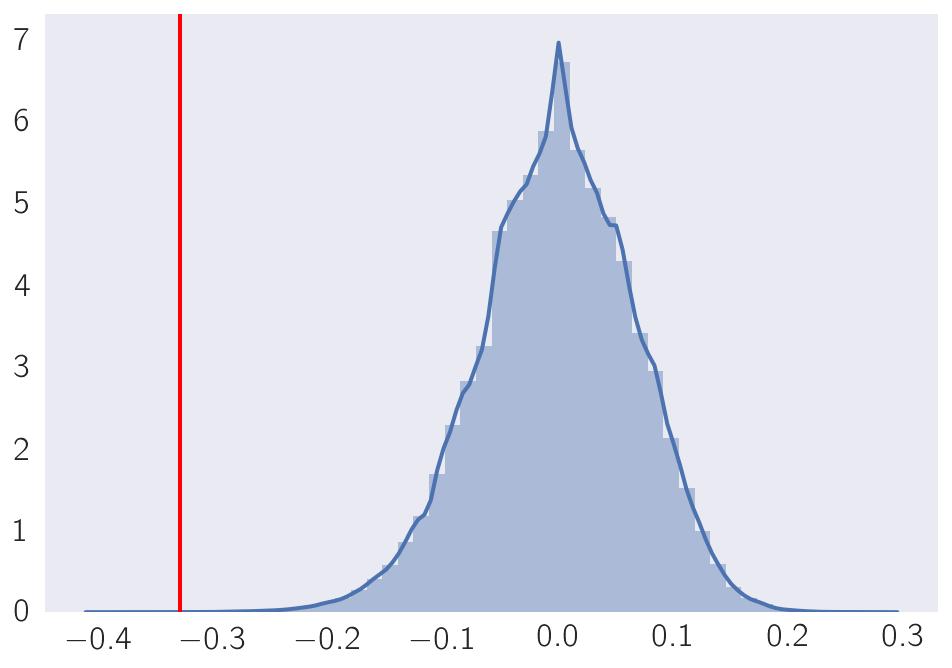

In [11]:
alpha = 10**-3  # statistical significance threshold
statistic = np.median  # statistic to use for testing

x = temp[temp['phenotypic class'] == 'bx93 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 associated'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=statistic)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)

significance(pval, alpha, 'bx93 associated', 'sy622 associated')

The medians between bx93 associated and sy622 specific are statistically significantly different.
pvalue is 0


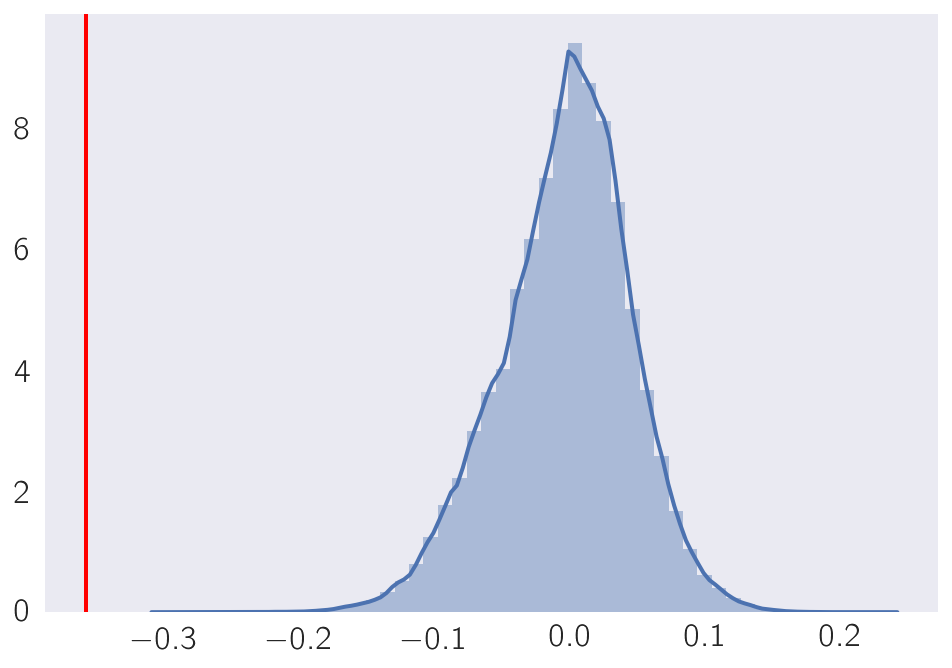

In [12]:
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
significance(pval, alpha, 'bx93 associated', 'sy622 specific')

The medians between sy622 associated and sy622 associated are NOT statistically significantly different.
pvalue is 0.14


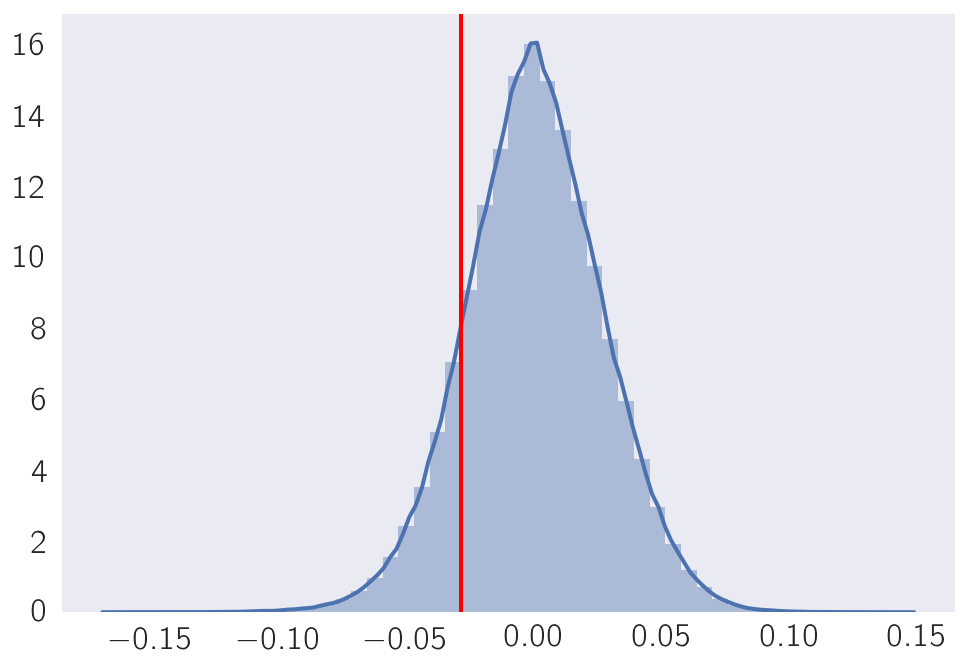

In [13]:
x = temp[temp['phenotypic class'] == 'sy622 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
significance(pval, alpha, 'sy622 associated', 'sy622 associated')

In [14]:
tidy.drop(['Unnamed: 0', 'absb', 'order'], axis=1).to_csv('../output/dpy_22_results.csv')

In [15]:
tissue = ea.fetch_dictionary('tissue')
pheno = ea.fetch_dictionary('phenotype')
go = ea.fetch_dictionary('go')

In [16]:
tissues = {}
phenos = {}
gos = {}
for key, value in classes.items():
    ids = tidy[tidy.target_id.isin(value)].ens_gene.unique()
    tissues[key] = ea.enrichment_analysis(ids, tissue, show=False, alpha=10**-3)
    phenos[key] = ea.enrichment_analysis(ids, pheno, show=False, alpha=10**-3)
    gos[key] = ea.enrichment_analysis(ids, go, show=False, alpha=10**-3)

In [17]:
for key, t in tissues.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 specific
                                 Tissue    Expected  Observed  \
234              intestine WBbt:0005772  527.986780       725   
228        muscular system WBbt:0005737  455.679684       584   
33   anal depressor muscle WBbt:0004292   42.043224        80   
8        epithelial system WBbt:0005730  360.176326       442   
112              sex organ WBbt:0008422  147.423115       198   

     Enrichment Fold Change       P value       Q value  
234                1.373140  3.997897e-19  1.099422e-16  
228                1.281602  1.926466e-10  2.648891e-08  
33                 1.902804  9.146513e-09  8.384304e-07  
8                  1.227177  3.303813e-06  2.271371e-04  
112                1.343073  1.030167e-05  5.665918e-04  
sy622 associated
                     Tissue    Expected  Observed  Enrichment Fold Change  \
247  intestine WBbt:0005772  288.135704       365                1.266764   

      P value   Q value  
247  0.000002  0.000463  
transhet specific
    

In [18]:
for key, t in phenos.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 specific
                                                Tissue   Expected  Observed  \
198          avoids bacterial lawn WBPhenotype:0000402  45.134276        87   
19               gonad vesiculated WBPhenotype:0001979  20.635716        42   
12   pleiotropic defects severe early emb WBPhenoty...  12.300107        28   

     Enrichment Fold Change       P value       Q value  
198                1.927582  8.377059e-10  1.801068e-07  
19                 2.035306  2.638123e-06  2.835982e-04  
12                 2.276403  9.122674e-06  6.537916e-04  


In [19]:
for key, t in gos.items():
    if len(t) != 0:
        print(key)
        print(t[t['Enrichment Fold Change'] > 3.5])

sy622 specific
                                                Tissue   Expected  Observed  \
151                      embryo development GO:0009790  86.995490       325   
106              post-embryonic development GO:0009791  62.396583       263   
109                                   aging GO:0007568  25.365970       133   
157                           mitochondrion GO:0005739  31.264418       112   
185                         collagen trimer GO:0005581   5.052034        39   
72            positive regulation of growth GO:0045927  10.791779        53   
57            multicellular organism growth GO:0035264  11.082734        52   
234                           molting cycle GO:0042303  12.087850        51   
139                 muscle cell development GO:0055001   4.523025        31   
78   cellular component assembly involved in morpho...   4.443674        30   
100    striated muscle cell differentiation GO:0051146   4.549475        30   
207                       contractile